## Before Starting...
Before getting into this, it would be better to read the SVCCA paper: https://arxiv.org/abs/1706.05806
And have a good understanding of what SVCCA does and the results to expect from it: https://github.com/google/svcca/

## Why SVCCA?
The reason for choosing SVCCA over a diagnostic classifier, for example, is that SVCCA can be run between different models and different layers, also trained on different data, making it model and dataset agnostic. This is a huge plus, since it can help test hypothesis on models trained on different levels of abstraction, for example. In this notebook, however, we will test activations within the same layer for different input classes. The question is: which classes share most similarity in the activations? Can any assumtpion be made on the results?

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import cca_core # This is google's svcca module: https://github.com/google/svcca/
import matplotlib.pyplot as plt
import numpy as np

print("torch version", torch.__version__)
print("torchvision version", torchvision.__version__)

# assert torch.__version__ == "1.7.0"

if torch.cuda.is_available():
    device = "cuda"

torch version 1.7.0
torchvision version 0.8.1


## Load CIFAR10

Load the CIFAR10 dataset with torchvision and create a dictionary of the classes for later use, we will map the labels to the class

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
id_classes = dict(enumerate(classes))
id_classes

Files already downloaded and verified
Files already downloaded and verified


{0: 'plane',
 1: 'car',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

## Create Model

We use the same model from PyTorch's introductory tutorial https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html.
We add some methods and the `self.activations` attribute to help us save the activations and analyze them.
The plot helper is from google's svcca module.
`_save activations` will save the activations for each label as numpy arrays.
`get_similarities` will calculate the SVCCA between the activations of each label, it will call `_reshape_same_layer_activations` since we are going to calculate similarities between activations of the same layer, but for different input classes.
We add in the forward step the points where we want to save activations.

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import pickle

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.activations = dict()
        
    def _save_activations(self, activations, name):
        """Saves activations in the self.activations attribute with the label name as key"""
        if name not in self.activations:
            self.activations[name] = []
        activations = activations.cpu().clone().detach().numpy()
        self.activations[name].append(activations)
    
    @staticmethod
    def _reshape_same_layer_activations(activations):
        """reshapes activation arrays with identical shapes according to google's svcca tutorial on CNN"""
        activations = np.vstack(activations)
        activations = activations.transpose((0,2,3,1))
        num_datapoints, h, w, channels = activations.shape
        activations_reshaped = activations.reshape((num_datapoints*h*w, channels))
        return activations_reshaped
    
    @staticmethod
    def _plot_helper(arr, xlabel, ylabel, i=None, j=None):
        if j and i:
            plt.plot(arr, lw=2.0, label=i+" : "+j)
        else:
            plt.plot(arr, lw=2.0)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(f"{i} : {j}")
        plt.grid()
        plt.legend()
    
    def get_similarities(self, threshold=0.1, layer=1, verbose=False):
        """For each saved labels' activations, calculates similarities with the other saved labels"""
        import time
        layer = str(layer)
        names = list(self.activations.keys())
        for i in range(len(names)):
            for j in range(len(names)):
                if names[i].endswith(layer) and names[j].endswith(layer) and i != j and j > i:
                    activations_reshaped1 = self._reshape_same_layer_activations(net.activations[names[i]])
                    activations_reshaped2 = self._reshape_same_layer_activations(net.activations[names[j]])
                    start = time.time()
                    f_results = cca_core.get_cca_similarity(activations_reshaped1.T, activations_reshaped2.T, verbose=False)
                    if f_results["cca_coef1"][0] > threshold: # SVCCA output values are already sorted
                        self._plot_helper(f_results["cca_coef1"], "CCA Coef idx", "CCA coef value", names[i], names[j])
                        if verbose:
                            print(f"{names[i]} : {names[j]}")
                            print(np.mean(f_results["cca_coef1"]), "CCA Coef idx", "CCA coef value")
    
    def forward(self, x, save_activations=False):
        """
        :params x: input vector
        :params save_activations: default False, should be provided a string which is the label's class name.
        """
        x = self.conv1(x)
        if save_activations:
            self._save_activations(x, save_activations+"_1")
        x = self.pool(F.relu(x))
        x = self.conv2(x)
        if save_activations:
            self._save_activations(x, save_activations+"_2")
        x = self.pool(F.relu(x))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)


## Training the model

We now train the model just like in the tutorial from PyTorch

In [4]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [5]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(device))
        loss = criterion(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')

[1,  1000] loss: 1.949
[1,  2000] loss: 1.718
[1,  3000] loss: 1.616
[1,  4000] loss: 1.525
[1,  5000] loss: 1.531
[1,  6000] loss: 1.476
[1,  7000] loss: 1.494
[1,  8000] loss: 1.424
[1,  9000] loss: 1.423
[1, 10000] loss: 1.399
[1, 11000] loss: 1.390
[1, 12000] loss: 1.380
Finished Training


## Testing and saving activations

Now we run the test set through the model. To keep things simple, the batch size for the test set is set to 1, so that we can easily check to which label the input belongs to and to which activations key it must be mapped to. So, we pass the class name as the `save_activations` parameter.

In [6]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device), save_activations=id_classes[labels[0].item()])
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to("cpu") == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


## Getting similarities

We now calculate similarities. The threshold will check for the highest node similarity score in the SVCCA results, so that we can filter low scoring nodes.

As we can see, ships and trucks seem to be the most similar, which kind of makes sense, they have very different shapes and colors than animals. while the second most similar pair is ships and horses (horses pop up often, maybe because in the images they are often seen on the side and so are developed horizontally like these other objects?

ship_1 : plane_1
0.021032266789417123 CCA Coef idx CCA coef value
ship_1 : car_1
0.021398713472072887 CCA Coef idx CCA coef value
ship_1 : truck_1
0.024893620275772854 CCA Coef idx CCA coef value
ship_1 : horse_1
0.02138085085716365 CCA Coef idx CCA coef value
plane_1 : truck_1
0.018434735209398995 CCA Coef idx CCA coef value
plane_1 : horse_1
0.01590062521039332 CCA Coef idx CCA coef value
car_1 : truck_1
0.019310375071298572 CCA Coef idx CCA coef value
truck_1 : horse_1
0.02143766228227528 CCA Coef idx CCA coef value


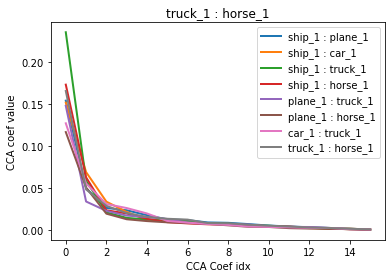

In [7]:
net.get_similarities(threshold=.1, verbose=True)               